In [1]:
%matplotlib inline
import glob, re
import numpy as np
import pandas as pd
import xgboost
#from sklearn import *
from datetime import datetime
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import pandas_profiling as pdp
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from xgboost import XGBRegressor
from sklearn import preprocessing, ensemble
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import accuracy_score
import logging
from logging.handlers import RotatingFileHandler
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

/Users/jordanvidal/python3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [5]:
logging.basicConfig(filename='report/test.log', level=logging.DEBUG, format='%(asctime)s :: %(levelname)s :: %(message)s',
                        datefmt='%m/%d/%Y %I:%M:%S %p')

In [6]:
logging.info('Loading the data...')

In [2]:
data = {
    'tra': pd.read_csv('data/air_visit_data.csv.zip', compression="zip"),
    'as': pd.read_csv('data/air_store_info.csv.zip', compression="zip"),
    'hs': pd.read_csv('data/hpg_store_info.csv.zip', compression="zip"),
    'ar': pd.read_csv('data/air_reserve.csv.zip', compression="zip"),
    'hr': pd.read_csv('data/hpg_reserve.csv.zip', compression="zip"),
    'id': pd.read_csv('data/store_id_relation.csv.zip', compression="zip"),
    'tes': pd.read_csv('data/sample_submission.csv.zip', compression="zip"),
    'hol': pd.read_csv('data/date_info.csv.zip', compression="zip").rename(columns={'calendar_date':'visit_date'})
    }

In [3]:
logging.info('Done with loading the data...')

In [4]:
#Merge between hpg and id_
data['hr'] = pd.merge(data['hr'], data['id'], how='inner', on=['hpg_store_id'])

In [5]:
%%time 
for df in ['ar','hr']:
    #convert to datetime + creation de "reserve_datetime_diff"
    data[df]['visit_datetime'] = pd.to_datetime(data[df]['visit_datetime'])
    data[df]['visit_datetime'] = data[df]['visit_datetime'].dt.date
    data[df]['reserve_datetime'] = pd.to_datetime(data[df]['reserve_datetime'])
    data[df]['reserve_datetime'] = data[df]['reserve_datetime'].dt.date
    data[df]['reserve_datetime_diff'] = data[df].apply(lambda r: (r['visit_datetime'] - r['reserve_datetime']).days, axis=1)
    # Ajout de la somme (tmp1) et de la moyenne (tmp2) du nombre de visiteurs et de reserve_datetime_diff par visites    
    tmp1 = data[df].groupby(['air_store_id','visit_datetime'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].sum().rename(columns={'visit_datetime':'visit_date', 'reserve_datetime_diff': 'rs1', 'reserve_visitors':'rv1'})
    tmp2 = data[df].groupby(['air_store_id','visit_datetime'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].mean().rename(columns={'visit_datetime':'visit_date', 'reserve_datetime_diff': 'rs2', 'reserve_visitors':'rv2'})
    data[df] = pd.merge(tmp1, tmp2, how='inner', on=['air_store_id','visit_date'])

CPU times: user 3.53 s, sys: 43 ms, total: 3.57 s
Wall time: 3.58 s


In [6]:
#convert train date into datetime
data['tra']['visit_date'] = pd.to_datetime(data['tra']['visit_date'])
data['tra']['dow'] = data['tra']['visit_date'].dt.dayofweek
data['tra']['year'] = data['tra']['visit_date'].dt.year
data['tra']['month'] = data['tra']['visit_date'].dt.month
data['tra']['visit_date'] = data['tra']['visit_date'].dt.date

In [7]:
#convert test date into datetime
data['tes']['visit_date'] = data['tes']['id'].map(lambda x: str(x).split('_')[2])
data['tes']['air_store_id'] = data['tes']['id'].map(lambda x: '_'.join(x.split('_')[:2]))
data['tes']['visit_date'] = pd.to_datetime(data['tes']['visit_date'])
data['tes']['dow'] = data['tes']['visit_date'].dt.dayofweek
data['tes']['year'] = data['tes']['visit_date'].dt.year
data['tes']['month'] = data['tes']['visit_date'].dt.month
data['tes']['visit_date'] = data['tes']['visit_date'].dt.date

In [8]:
#Creation des unique_store dataset
unique_stores = data['tes']['air_store_id'].unique()
stores = pd.concat([pd.DataFrame({'air_store_id': unique_stores, 'dow': [i]*len(unique_stores)}) for i in range(7)], axis=0, ignore_index=True).reset_index(drop=True)

In [9]:
# creation of min, mean, median, max and count visitors for every air_store_id
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].min().rename(columns={'visitors':'min_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow']) 
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].mean().rename(columns={'visitors':'mean_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].median().rename(columns={'visitors':'median_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].max().rename(columns={'visitors':'max_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].count().rename(columns={'visitors':'count_observations'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow']) 

stores = pd.merge(stores, data['as'], how='left', on=['air_store_id']) 

In [10]:
stores['air_genre_name'] = stores['air_genre_name'].map(lambda x: str(str(x).replace('/',' ')))
stores['air_area_name'] = stores['air_area_name'].map(lambda x: str(str(x).replace('-',' ')))
#Label encoder pour les air_genre_name and air_area_name
lbl = preprocessing.LabelEncoder()
for i in range(10):
    stores['air_genre_name'+str(i)] = lbl.fit_transform(stores['air_genre_name'].map(lambda x: str(str(x).split(' ')[i]) if len(str(x).split(' '))>i else ''))
    stores['air_area_name'+str(i)] = lbl.fit_transform(stores['air_area_name'].map(lambda x: str(str(x).split(' ')[i]) if len(str(x).split(' '))>i else ''))
stores['air_genre_name'] = lbl.fit_transform(stores['air_genre_name'])
stores['air_area_name'] = lbl.fit_transform(stores['air_area_name'])

In [11]:
#convert date to datetime in holiday dataset
data['hol']['visit_date'] = pd.to_datetime(data['hol']['visit_date'])
data['hol']['day_of_week'] = lbl.fit_transform(data['hol']['day_of_week'])
data['hol']['visit_date'] = data['hol']['visit_date'].dt.date

In [12]:
#creation of train and test by merging train/test and stores dataset
train = pd.merge(data['tra'], data['hol'], how='left', on=['visit_date']) 
test = pd.merge(data['tes'], data['hol'], how='left', on=['visit_date']) 
train = pd.merge(train, stores, how='left', on=['air_store_id','dow']) 
test = pd.merge(test, stores, how='left', on=['air_store_id','dow'])

In [13]:
for df in ['ar','hr']:
    train = pd.merge(train, data[df], how='left', on=['air_store_id','visit_date']) 
    test = pd.merge(test, data[df], how='left', on=['air_store_id','visit_date'])

In [14]:
#Recuperation des id des store present dans le train
train['id'] = train.apply(lambda r: '_'.join([str(r['air_store_id']), str(r['visit_date'])]), axis=1)

#Calcul de la somme, moyenne du nombre de visiteurs + moyenne du nombres de jours d'ecart entre reservation et visite au restaurant
train['total_reserv_sum'] = train['rv1_x'] + train['rv1_y']
train['total_reserv_mean'] = (train['rv2_x'] + train['rv2_y']) / 2
train['total_reserv_dt_diff_mean'] = (train['rs2_x'] + train['rs2_y']) / 2

test['total_reserv_sum'] = test['rv1_x'] + test['rv1_y']
test['total_reserv_mean'] = (test['rv2_x'] + test['rv2_y']) / 2
test['total_reserv_dt_diff_mean'] = (test['rs2_x'] + test['rs2_y']) / 2

In [15]:
# NEW FEATURES 
# 
train['date_int'] = train['visit_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
test['date_int'] = test['visit_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
train['var_max_lat'] = train['latitude'].max() - train['latitude']
train['var_max_long'] = train['longitude'].max() - train['longitude']
test['var_max_lat'] = test['latitude'].max() - test['latitude']
test['var_max_long'] = test['longitude'].max() - test['longitude']

In [16]:
# NEW FEATURES FROM Georgii Vyshnia
train['lon_plus_lat'] = train['longitude'] + train['latitude'] 
test['lon_plus_lat'] = test['longitude'] + test['latitude']

In [17]:
lbl = preprocessing.LabelEncoder()
train['air_store_id2'] = lbl.fit_transform(train['air_store_id'])
test['air_store_id2'] = lbl.transform(test['air_store_id'])

In [18]:
col = [c for c in train if c not in ['id', 'air_store_id', 'visit_date','visitors']]
train = train.fillna(-1)
test = test.fillna(-1)

## End of FE

In [21]:
#before FE
data['tra'].shape
#after FE
train.shape

(252108, 54)

In [22]:
print('Train Features names: {}'.format(train.columns.values))

Train Features names: ['air_store_id' 'visit_date' 'visitors' 'dow' 'year' 'month' 'day_of_week'
 'holiday_flg' 'min_visitors' 'mean_visitors' 'median_visitors'
 'max_visitors' 'count_observations' 'air_genre_name' 'air_area_name'
 'latitude' 'longitude' 'air_genre_name0' 'air_area_name0'
 'air_genre_name1' 'air_area_name1' 'air_genre_name2' 'air_area_name2'
 'air_genre_name3' 'air_area_name3' 'air_genre_name4' 'air_area_name4'
 'air_genre_name5' 'air_area_name5' 'air_genre_name6' 'air_area_name6'
 'air_genre_name7' 'air_area_name7' 'air_genre_name8' 'air_area_name8'
 'air_genre_name9' 'air_area_name9' 'rs1_x' 'rv1_x' 'rs2_x' 'rv2_x' 'rs1_y'
 'rv1_y' 'rs2_y' 'rv2_y' 'id' 'total_reserv_sum' 'total_reserv_mean'
 'total_reserv_dt_diff_mean' 'date_int' 'var_max_lat' 'var_max_long'
 'lon_plus_lat' 'air_store_id2']


In [23]:
print('Test Features names: {}'.format(test.columns.values))

Test Features names: ['id' 'visitors' 'visit_date' 'air_store_id' 'dow' 'year' 'month'
 'day_of_week' 'holiday_flg' 'min_visitors' 'mean_visitors'
 'median_visitors' 'max_visitors' 'count_observations' 'air_genre_name'
 'air_area_name' 'latitude' 'longitude' 'air_genre_name0' 'air_area_name0'
 'air_genre_name1' 'air_area_name1' 'air_genre_name2' 'air_area_name2'
 'air_genre_name3' 'air_area_name3' 'air_genre_name4' 'air_area_name4'
 'air_genre_name5' 'air_area_name5' 'air_genre_name6' 'air_area_name6'
 'air_genre_name7' 'air_area_name7' 'air_genre_name8' 'air_area_name8'
 'air_genre_name9' 'air_area_name9' 'rs1_x' 'rv1_x' 'rs2_x' 'rv2_x' 'rs1_y'
 'rv1_y' 'rs2_y' 'rv2_y' 'total_reserv_sum' 'total_reserv_mean'
 'total_reserv_dt_diff_mean' 'date_int' 'var_max_lat' 'var_max_long'
 'lon_plus_lat' 'air_store_id2']


In [24]:
# Shape of the train Dataset
print('Number of raws: {}'.format(len(train)))
print('Number of columns: {}'.format(len(train.columns.values)))

Number of raws: 252108
Number of columns: 54


In [25]:
# Shape of the Dataset
print('Number of raw in test: {}'.format(len(test)))
print('Number of columns: {}'.format(len(test.columns.values)))

Number of raw in test: 32019
Number of columns: 54


In [19]:
y = train.pop('visitors')

In [58]:
#train['id'] = train.apply(lambda r: '_'.join([str(r['air_store_id']), str(r['visit_date'])]), axis=1)
#train['air_store_id'] = train['air_store_id'].map(lambda x: '_'.join(x.split('_')[:2]))
#train['visit_date'] = train['visit_date'].map(lambda x: str(x).split('_')[2])

In [20]:
#X = train[col]
X_train, X_test, y_train, y_test = train_test_split(train[col], y, test_size=0.2, random_state=42)

In [21]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((201686, 50), (201686,), (50422, 50), (50422,))

### Linear Regression

In [64]:
%%time
lm = LinearRegression().fit(X_train, y_train)
train_error_lm = round(mean_squared_error(y_train, lm.predict(X_train)), 3)
test_error_lm = round(mean_squared_error(y_test, lm.predict(X_test)), 3)
print("train error: {}".format(train_error_lm))
print("test error: {}".format(test_error_lm))

train error: 117.181
test error: 126.047
CPU times: user 1.06 s, sys: 70.8 ms, total: 1.13 s
Wall time: 652 ms


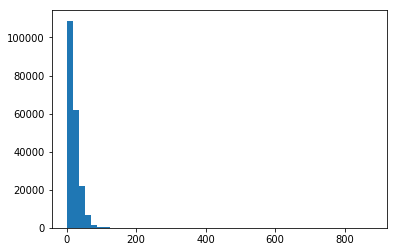

In [76]:
plt.hist(y_train, bins=50);
plt.show()

In [73]:
def scatter_predictions(y_pred, y_true):
    plt.figure(figsize=(10,10))
    plt.xlabel('prediction')
    plt.ylabel('true target')
    plt.xlim(-1, 50)
    plt.ylim(-1, 50)
    plt.scatter(y_pred, y_true)

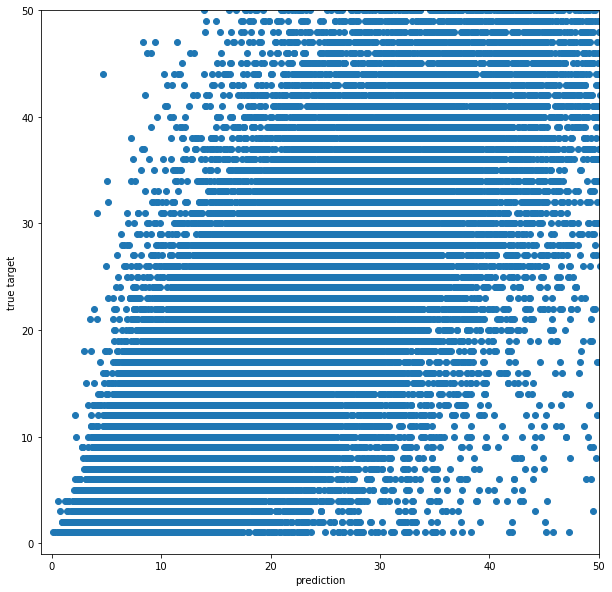

In [74]:
scatter_predictions(lm.predict(X_test), y_test)

### Logistic Regression

In [32]:
def test_model(model, X_test, y_test):
    p_test = model.predict_proba(X_test)
    return mean_squared_error(y_test, p_test.argmax(axis=1))

In [30]:
model = LogisticRegression(penalty='l2', C=1.0, n_jobs=4)

In [31]:
%%time
model.fit(X_train, y_train)

CPU times: user 5min 52s, sys: 1.07 s, total: 5min 53s
Wall time: 5min 54s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=4,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [37]:
%%time
model.predict(X_test)
score_lr = test_model(model, X_test, y_test)
print('Logistic Regression score: {}'.format(score_lr))

Logistic Regression score: 548.124152155805 3
CPU times: user 393 ms, sys: 76 ms, total: 469 ms
Wall time: 298 ms


### Random Forest

In [30]:
%%time
rf.fit(X_train, y_train)

CPU times: user 10.1 s, sys: 428 ms, total: 10.5 s
Wall time: 2 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [33]:
%%time
score_rf = test_model(rf, X_test, y_test)
print('Random Forest score: {}'.format(score_rf))

Random Forest score: 161.65826424973227
CPU times: user 1.41 s, sys: 544 ms, total: 1.96 s
Wall time: 563 ms


In [34]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
dtrain = xgboost.DMatrix(train[col], label=y)


In [35]:
#dtrain.feature_names

In [ ]:
# Print the feature ranking
print("Feature ranking:")

for f in range(train[col].shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

In [37]:
importances

array([ 0.02916304,  0.01907316,  0.08615948,  0.02750185,  0.00301467,
        0.04490935,  0.10052822,  0.11451984,  0.06841767,  0.04019435,
        0.01687382,  0.02288938,  0.02265338,  0.02034853,  0.01717962,
        0.00805409,  0.01655563,  0.00510357,  0.00161309,  0.01963426,
        0.        ,  0.00463234,  0.        ,  0.02541309,  0.        ,
        0.00327214,  0.        ,  0.00022827,  0.        ,  0.        ,
        0.        ,  0.        ,  0.00020505,  0.        ,  0.00799226,
        0.01458276,  0.00769236,  0.00915739,  0.00381018,  0.00259648,
        0.0030345 ,  0.00269461,  0.00112512,  0.00105055,  0.00097573,
        0.12465533,  0.02128452,  0.02150489,  0.02082185,  0.03888359])

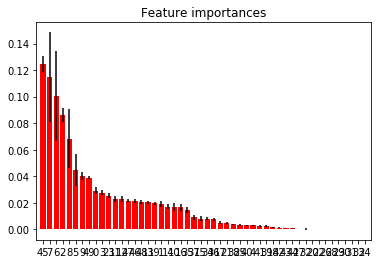

In [38]:
plt.figure()
plt.title("Feature importances")
plt.bar(range(train[col].shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(train[col].shape[1]), indices)
plt.xlim([-1, train[col].shape[1]])
plt.show()

In [87]:
dtrain.feature_names[44]

'total_reserv_dt_diff_mean'

In [ ]:
#final_gb = xgboost.train(our_params, dtrain, num_boost_round = 432)
#xgdmat = xgb.DMatrix(final_train, y_train)
#xgboost.plot_importance(final_gb)

In [52]:
#xgboost.DMatrix()
#mapper = {'f{0}'.format(i): v for i, v in enumerate(dtrain.feature_names)}
#mapped = {mapper[k]: v for k, v in bst.get_fscore().items()}
#mapped
#xgboost.plot_importance(mapped, color='red')

### GridSearch on RF

In [ ]:
params = dict(max_depth=list(range(8, 12)),
              n_estimators=list(range(30, 110, 10)))
mygcv = GridSearchCV(rf, param_grid=params).fit(X_train, y_train)

In [ ]:
print('Tested parameters: {}'.format(mygcv.cv_results_['params']))
print('Best Estimator: {}'.format(mygcv.best_estimator_))
print('Best Parameters: {}'.format(mygcv.best_params_))

Tested parameters: [{'max_depth': 8, 'n_estimators': 30}, {'max_depth': 8, 'n_estimators': 40}, {'max_depth': 8, 'n_estimators': 50}, {'max_depth': 8, 'n_estimators': 60}, {'max_depth': 8, 'n_estimators': 70}, {'max_depth': 8, 'n_estimators': 80}, {'max_depth': 8, 'n_estimators': 90}, {'max_depth': 8, 'n_estimators': 100}, {'max_depth': 9, 'n_estimators': 30}, {'max_depth': 9, 'n_estimators': 40}, {'max_depth': 9, 'n_estimators': 50}, {'max_depth': 9, 'n_estimators': 60}, {'max_depth': 9, 'n_estimators': 70}, {'max_depth': 9, 'n_estimators': 80}, {'max_depth': 9, 'n_estimators': 90}, {'max_depth': 9, 'n_estimators': 100}, {'max_depth': 10, 'n_estimators': 30}, {'max_depth': 10, 'n_estimators': 40}, {'max_depth': 10, 'n_estimators': 50}, {'max_depth': 10, 'n_estimators': 60}, {'max_depth': 10, 'n_estimators': 70}, {'max_depth': 10, 'n_estimators': 80}, {'max_depth': 10, 'n_estimators': 90}, {'max_depth': 10, 'n_estimators': 100}, {'max_depth': 11, 'n_estimators': 30}, {'max_depth': 11, 'n_estimators': 40}, {'max_depth': 11, 'n_estimators': 50}, {'max_depth': 11, 'n_estimators': 60}, {'max_depth': 11, 'n_estimators': 70}, {'max_depth': 11, 'n_estimators': 80}, {'max_depth': 11, 'n_estimators': 90}, {'max_depth': 11, 'n_estimators': 100}]
Best Estimator: RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=11,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
Best Parameters: {'max_depth': 11, 'n_estimators': 90}

Let's try our Best Paramaters to random forest classifier and xgboost

In [ ]:
%%time
rf2 = RandomForestRegressor(n_estimators=90, max_depth=11, random_state=42)
rf2.fit(X_train, y_train)
train_error_rf2 = round(mean_squared_error(y_train, rf2.predict(X_train)), 3)
test_error_rf2 = round(mean_squared_error(y_test, rf2.predict(X_test)), 3)
print("train error: {}".format(train_error_rf2))
print("test error with Best Parameters: {}".format(test_error_rf2))
print("test error without Best Parameters: {}".format(test_error_rf))

### Quick & dirty with XGBoost

In [79]:
#score_xgb = test_model(xgb, X_test, y_test)
#print('XGB score: {}'.format(score_xgb))

In [ ]:
model3 = XGBRegressor(learning_rate=0.2, random_state=3, n_estimators=250, subsample=0.8, colsample_bytree=0.8, max_depth =10)
model3.fit(train[col], np.log1p(train['visitors'].values))
preds3 = model3.predict(train[col])

In [56]:
%%time
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
train_error_xgb = round(mean_squared_error(y_train, xgb.predict(X_train)), 3)
test_error_xgb = round(mean_squared_error(y_test, xgb.predict(X_test)), 3)
print("train error: {}".format(train_error_xgb))
print("test error: {}".format(test_error_xgb))

train error: 111.321
test error: 122.213
CPU times: user 25 s, sys: 195 ms, total: 25.2 s
Wall time: 25.2 s


### Grid Search on XGBOOST

In [ ]:
%%time
xgb2 = XGBRegressor(n_estimators=ACHANGER, max_depth=ACHANGER)
xgb2.fit(X_train, y_train)
train_error_xgb2 = round(mean_squared_error(y_train, xgb2.predict(X_train)), 3)
test_error_xgb2 = round(mean_squared_error(y_test, xgb2.predict(X_test)), 3)
print("train error: {}".format(train_error_xgb2))
print("test error with Best Parameters: {}".format(test_error_xgb2))
print("test error without Best Parameters: {}".format(test_error_xgb))

In [335]:
%%time
params = dict(max_depth=list(range(5, 10)), n_estimators=[100], learning_rate=np.arange(0, 1, 0.005))
grid_search = GridSearchCV(xgb, param_grid=params).fit(X_train, y_train)

KeyboardInterrupt: 

In [336]:
print('Best Estimator: {}'.format(grid_search.best_estimator_))
print(colored('Best Parameters: {}'.format(grid_search.best_params_), 'green'))

AttributeError: module 'sklearn.grid_search' has no attribute 'best_estimator_'

Let's compute our model with best parameters from Grid Search

In [ ]:
%%time
params = grid_search.best_params_
xgb_grid = XGBRegressor(**params)
xgb_grid.fit(X_train, y_train)
train_error_xgb_grid = round(median_absolute_error(y_train, xgb_grid.predict(X_train)), 3)
test_error_xgb_grid = round(median_absolute_error(y_test, xgb_grid.predict(X_test)), 3)
print("train error: {}".format(train_error_xgb_grid))
print("test error: {}".format(test_error_xgb_grid))

In [ ]:
perf = round((test_error_xgb - test_error_xgb_grid)*100, 2)
print("Performance : +{}%".format(perf))

### Permutation importance

In [66]:
def permutation_importance(predict_function, X, y, loss_function):
    baseline = loss_function(y, predict_function(X))
    feature_list = X.columns
    importance={}
    for i, feature_name in enumerate(feature_list):
        X_permute = X.copy()
        X_permute[feature_name] = np.random.permutation(X_permute[feature_name])
        importance[feature_name] = loss_function(y, predict_function(X_permute)) - baseline
    return pd.Series(importance, name='permutation_importance')

In [67]:
def classif_error(y_true, y_pred):
    return 1 - accuracy_score(y_true, np.argmax(y_pred.values, axis=1))

In [68]:
def predict_function(X):
    return pipeline(X, label_encoders=label_encoders, model=rf)

In [69]:
feature_importance = permutation_importance(predict_function, X_train, y_test, classif_error)

NameError: name 'label_encoders' is not defined

In [ ]:
feature_importance.sort_values().plot(kind='barh')

### Hyperopt

Avec les paramètres par défaut de XGBregressor

In [22]:
def get_final_parameters(best_params, origin_model_d, current_model):
    """
    Fix the string parameters returned by hyperopt.
    Use the index given by hyperopt to find the real string value
    for a specific parameter
    """
    for element_p in list(best_params.keys()):
        if isinstance(
                origin_model_d[current_model][1][element_p],
                hyperopt.pyll.base.Apply):
            if origin_model_d[current_model][1][element_p].name == "float":
                pass
            elif origin_model_d[current_model][1][element_p].name == "switch":
                apply_obj = origin_model_d[current_model][1][element_p]
                literal_obj = apply_obj.pos_args[best_params[element_p] + 1]
                best_params[element_p] = literal_obj.obj
            else:
                pass
        else:
            pass
    return best_params

def regression_params_opt(
        origin_model_d,
        current_model,
        X_train,
        X_test,
        y_train,
        y_test):
    print(current_model)
    best = 0
    max_eval = 10
    trials = Trials()

    def rmse_score(params):
        model_fit = origin_model_d[current_model][0](
            **params).fit(X_train, y_train, eval_set=[(X_train,y_train),(X_test,y_test),],early_stopping_rounds=50)
        y_pred_train = model_fit.predict(X_test)
        loss = mean_squared_error(y_test, y_pred_train)**0.5
        params['best_iteration'] = model_fit.best_iteration
        list_result_hyperopt.append((loss, params))
        return {'loss': loss, 'status': STATUS_OK}

    best = fmin(rmse_score,
                origin_model_d[current_model][1],
                algo=tpe.suggest,
                max_evals=max_eval,
                trials=trials)
    print(best)
    print(best.keys())
    print("\n")
    return get_final_parameters(best, origin_model_d, current_model)

if __name__ == '__main__':

    xgbr_d = {'gamma': hp.quniform('gamma', 0.0, 5.0, 0.1),
              'learning_rate': hp.choice('learning_rate', [0.1]),
              'colsample_bytree': hp.quniform('colsample_bytree',
                                              0.3,
                                              1.,
                                              0.05),
              'max_depth': hp.choice('max_depth', list(range(5, 10))),
              'min_child_weight': hp.quniform('min_child_weight', 1., 5., 1),
              'subsample': hp.quniform('subsample', 0.6, 1, 0.05),
              'nthread': hp.choice('nthread', [-1]),
              'n_estimators': hp.choice('n_estimators', [1500]),
              'objective': hp.choice('objective', ['reg:linear']),
              'reg_lambda': hp.quniform('reg_alpha', 0.0, 4.0, 0.1),
              'reg_alpha': hp.quniform('reg_lambda', 0.0, 4.0, 0.1)}

    base_model = {"XGBRegressor": [XGBRegressor, xgbr_d]}

    list_result_hyperopt = []
    hyper_parametres = regression_params_opt(
        origin_model_d=base_model,
        current_model="XGBRegressor",
        X_train=X_train,
        X_test=X_test,
        y_train=y_train,
        y_test=y_test
    )

XGBRegressor
[0]	validation_0-rmse:24.2279	validation_1-rmse:24.5415
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:22.3163	validation_1-rmse:22.6368
[2]	validation_0-rmse:20.6353	validation_1-rmse:20.9639
[3]	validation_0-rmse:19.1649	validation_1-rmse:19.5027
[4]	validation_0-rmse:17.8799	validation_1-rmse:18.227
[5]	validation_0-rmse:16.7672	validation_1-rmse:17.1245
[6]	validation_0-rmse:15.8047	validation_1-rmse:16.1746
[7]	validation_0-rmse:14.9752	validation_1-rmse:15.356
[8]	validation_0-rmse:14.2677	validation_1-rmse:14.6591
[9]	validation_0-rmse:13.6658	validation_1-rmse:14.0659
[10]	validation_0-rmse:13.151	validation_1-rmse:13.5593
[11]	validation_0-rmse:12.7199	validation_1-rmse:13.1379
[12]	validation_0-rmse:12.3588	validation_1-rmse:12.7859
[13]	validation_0-rmse:12.0548	validation_1-rmse:12.4907
[14]	validation_0-rmse:11.803	validation_1-

[38]	validation_0-rmse:10.4485	validation_1-rmse:11.0483
[39]	validation_0-rmse:10.4413	validation_1-rmse:11.0415
[40]	validation_0-rmse:10.4296	validation_1-rmse:11.0387
[41]	validation_0-rmse:10.425	validation_1-rmse:11.0338
[42]	validation_0-rmse:10.4185	validation_1-rmse:11.0298
[43]	validation_0-rmse:10.4128	validation_1-rmse:11.0257
[44]	validation_0-rmse:10.4057	validation_1-rmse:11.0219
[45]	validation_0-rmse:10.4009	validation_1-rmse:11.0197
[46]	validation_0-rmse:10.3894	validation_1-rmse:11.014
[47]	validation_0-rmse:10.3845	validation_1-rmse:11.0107
[48]	validation_0-rmse:10.3741	validation_1-rmse:11.0109
[49]	validation_0-rmse:10.3679	validation_1-rmse:11.0073
[50]	validation_0-rmse:10.3609	validation_1-rmse:11.0132
[51]	validation_0-rmse:10.35	validation_1-rmse:11.0227
[52]	validation_0-rmse:10.3467	validation_1-rmse:11.0207
[53]	validation_0-rmse:10.3432	validation_1-rmse:11.0185
[54]	validation_0-rmse:10.3369	validation_1-rmse:11.0171
[55]	validation_0-rmse:10.3281	vali

[79]	validation_0-rmse:9.78244	validation_1-rmse:10.8799
[80]	validation_0-rmse:9.77112	validation_1-rmse:10.8753
[81]	validation_0-rmse:9.76185	validation_1-rmse:10.8737
[82]	validation_0-rmse:9.75914	validation_1-rmse:10.874
[83]	validation_0-rmse:9.75281	validation_1-rmse:10.8749
[84]	validation_0-rmse:9.75013	validation_1-rmse:10.8731
[85]	validation_0-rmse:9.7477	validation_1-rmse:10.8721
[86]	validation_0-rmse:9.73895	validation_1-rmse:10.8682
[87]	validation_0-rmse:9.73872	validation_1-rmse:10.8683
[88]	validation_0-rmse:9.73266	validation_1-rmse:10.87
[89]	validation_0-rmse:9.72809	validation_1-rmse:10.8674
[90]	validation_0-rmse:9.7209	validation_1-rmse:10.8655
[91]	validation_0-rmse:9.71708	validation_1-rmse:10.8647
[92]	validation_0-rmse:9.71145	validation_1-rmse:10.8619
[93]	validation_0-rmse:9.70283	validation_1-rmse:10.8641
[94]	validation_0-rmse:9.69745	validation_1-rmse:10.8678
[95]	validation_0-rmse:9.69365	validation_1-rmse:10.8658
[96]	validation_0-rmse:9.69081	valid

[4]	validation_0-rmse:18.4889	validation_1-rmse:18.8469
[5]	validation_0-rmse:17.4884	validation_1-rmse:17.8566
[6]	validation_0-rmse:16.5411	validation_1-rmse:16.9189
[7]	validation_0-rmse:15.787	validation_1-rmse:16.1729
[8]	validation_0-rmse:14.9906	validation_1-rmse:15.3853
[9]	validation_0-rmse:14.4068	validation_1-rmse:14.8113
[10]	validation_0-rmse:13.8106	validation_1-rmse:14.2201
[11]	validation_0-rmse:13.3027	validation_1-rmse:13.7188
[12]	validation_0-rmse:12.9827	validation_1-rmse:13.4033
[13]	validation_0-rmse:12.7505	validation_1-rmse:13.1778
[14]	validation_0-rmse:12.4873	validation_1-rmse:12.9195
[15]	validation_0-rmse:12.1999	validation_1-rmse:12.6366
[16]	validation_0-rmse:12.0194	validation_1-rmse:12.4566
[17]	validation_0-rmse:11.8678	validation_1-rmse:12.3092
[18]	validation_0-rmse:11.7399	validation_1-rmse:12.1838
[19]	validation_0-rmse:11.576	validation_1-rmse:12.0203
[20]	validation_0-rmse:11.4922	validation_1-rmse:11.9385
[21]	validation_0-rmse:11.4187	validati

[148]	validation_0-rmse:10.3242	validation_1-rmse:10.9916
[149]	validation_0-rmse:10.3224	validation_1-rmse:10.9899
[150]	validation_0-rmse:10.3214	validation_1-rmse:10.9901
[151]	validation_0-rmse:10.321	validation_1-rmse:10.9893
[152]	validation_0-rmse:10.3174	validation_1-rmse:10.9869
[153]	validation_0-rmse:10.3168	validation_1-rmse:10.9865
[154]	validation_0-rmse:10.315	validation_1-rmse:10.9855
[155]	validation_0-rmse:10.3131	validation_1-rmse:10.9837
[156]	validation_0-rmse:10.312	validation_1-rmse:10.9832
[157]	validation_0-rmse:10.3113	validation_1-rmse:10.9828
[158]	validation_0-rmse:10.309	validation_1-rmse:10.9809
[159]	validation_0-rmse:10.3057	validation_1-rmse:10.9794
[160]	validation_0-rmse:10.303	validation_1-rmse:10.9771
[161]	validation_0-rmse:10.3017	validation_1-rmse:10.9778
[162]	validation_0-rmse:10.2981	validation_1-rmse:10.979
[163]	validation_0-rmse:10.2763	validation_1-rmse:10.9793
[164]	validation_0-rmse:10.272	validation_1-rmse:10.983
[165]	validation_0-rms

[6]	validation_0-rmse:15.7421	validation_1-rmse:16.1456
[7]	validation_0-rmse:14.9046	validation_1-rmse:15.3264
[8]	validation_0-rmse:14.1911	validation_1-rmse:14.6273
[9]	validation_0-rmse:13.5809	validation_1-rmse:14.0304
[10]	validation_0-rmse:13.0629	validation_1-rmse:13.5249
[11]	validation_0-rmse:12.6266	validation_1-rmse:13.1064
[12]	validation_0-rmse:12.2557	validation_1-rmse:12.7521
[13]	validation_0-rmse:11.9427	validation_1-rmse:12.4597
[14]	validation_0-rmse:11.6834	validation_1-rmse:12.2108
[15]	validation_0-rmse:11.4651	validation_1-rmse:12.0093
[16]	validation_0-rmse:11.2816	validation_1-rmse:11.8377
[17]	validation_0-rmse:11.1332	validation_1-rmse:11.6965
[18]	validation_0-rmse:11.0082	validation_1-rmse:11.5792
[19]	validation_0-rmse:10.9076	validation_1-rmse:11.4832
[20]	validation_0-rmse:10.8151	validation_1-rmse:11.4
[21]	validation_0-rmse:10.739	validation_1-rmse:11.3351
[22]	validation_0-rmse:10.67	validation_1-rmse:11.2808
[23]	validation_0-rmse:10.6139	validation

[7]	validation_0-rmse:15.8033	validation_1-rmse:16.1815
[8]	validation_0-rmse:15.0074	validation_1-rmse:15.3931
[9]	validation_0-rmse:14.4233	validation_1-rmse:14.8168
[10]	validation_0-rmse:13.8273	validation_1-rmse:14.2258
[11]	validation_0-rmse:13.3203	validation_1-rmse:13.7248
[12]	validation_0-rmse:13.0002	validation_1-rmse:13.4096
[13]	validation_0-rmse:12.7683	validation_1-rmse:13.1837
[14]	validation_0-rmse:12.5043	validation_1-rmse:12.9245
[15]	validation_0-rmse:12.2168	validation_1-rmse:12.6413
[16]	validation_0-rmse:12.0359	validation_1-rmse:12.461
[17]	validation_0-rmse:11.8839	validation_1-rmse:12.3128
[18]	validation_0-rmse:11.756	validation_1-rmse:12.1874
[19]	validation_0-rmse:11.5914	validation_1-rmse:12.0237
[20]	validation_0-rmse:11.5074	validation_1-rmse:11.9431
[21]	validation_0-rmse:11.434	validation_1-rmse:11.8726
[22]	validation_0-rmse:11.3869	validation_1-rmse:11.8284
[23]	validation_0-rmse:11.2861	validation_1-rmse:11.7287
[24]	validation_0-rmse:11.242	validat

[151]	validation_0-rmse:10.349	validation_1-rmse:10.9855
[152]	validation_0-rmse:10.3477	validation_1-rmse:10.9847
[153]	validation_0-rmse:10.3471	validation_1-rmse:10.9843
[154]	validation_0-rmse:10.3441	validation_1-rmse:10.9818
[155]	validation_0-rmse:10.3424	validation_1-rmse:10.9803
[156]	validation_0-rmse:10.3412	validation_1-rmse:10.9794
[157]	validation_0-rmse:10.3385	validation_1-rmse:10.9779
[158]	validation_0-rmse:10.3367	validation_1-rmse:10.9761
[159]	validation_0-rmse:10.3331	validation_1-rmse:10.9739
[160]	validation_0-rmse:10.331	validation_1-rmse:10.9729
[161]	validation_0-rmse:10.3297	validation_1-rmse:10.9723
[162]	validation_0-rmse:10.3244	validation_1-rmse:10.9722
[163]	validation_0-rmse:10.3167	validation_1-rmse:10.972
[164]	validation_0-rmse:10.312	validation_1-rmse:10.974
[165]	validation_0-rmse:10.311	validation_1-rmse:10.974
[166]	validation_0-rmse:10.3098	validation_1-rmse:10.9737
[167]	validation_0-rmse:10.309	validation_1-rmse:10.9741
[168]	validation_0-rms

[293]	validation_0-rmse:10.1181	validation_1-rmse:10.964
[294]	validation_0-rmse:10.1167	validation_1-rmse:10.9646
[295]	validation_0-rmse:10.1117	validation_1-rmse:10.9647
[296]	validation_0-rmse:10.1084	validation_1-rmse:10.9658
[297]	validation_0-rmse:10.108	validation_1-rmse:10.9659
[298]	validation_0-rmse:10.1055	validation_1-rmse:10.9641
[299]	validation_0-rmse:10.1052	validation_1-rmse:10.9639
[300]	validation_0-rmse:10.1008	validation_1-rmse:10.9666
[301]	validation_0-rmse:10.0989	validation_1-rmse:10.9659
[302]	validation_0-rmse:10.0981	validation_1-rmse:10.9657
[303]	validation_0-rmse:10.0959	validation_1-rmse:10.9636
[304]	validation_0-rmse:10.0957	validation_1-rmse:10.9636
[305]	validation_0-rmse:10.0952	validation_1-rmse:10.9636
[306]	validation_0-rmse:10.0948	validation_1-rmse:10.9635
[307]	validation_0-rmse:10.0946	validation_1-rmse:10.964
[308]	validation_0-rmse:10.0939	validation_1-rmse:10.9638
[309]	validation_0-rmse:10.0928	validation_1-rmse:10.9625
[310]	validation_

[24]	validation_0-rmse:10.3259	validation_1-rmse:11.1638
[25]	validation_0-rmse:10.2752	validation_1-rmse:11.131
[26]	validation_0-rmse:10.2281	validation_1-rmse:11.0988
[27]	validation_0-rmse:10.193	validation_1-rmse:11.0766
[28]	validation_0-rmse:10.1494	validation_1-rmse:11.0572
[29]	validation_0-rmse:10.1236	validation_1-rmse:11.0416
[30]	validation_0-rmse:10.0929	validation_1-rmse:11.0279
[31]	validation_0-rmse:10.0742	validation_1-rmse:11.0193
[32]	validation_0-rmse:10.0529	validation_1-rmse:11.0063
[33]	validation_0-rmse:10.0336	validation_1-rmse:11.0015
[34]	validation_0-rmse:10.0178	validation_1-rmse:10.987
[35]	validation_0-rmse:9.99425	validation_1-rmse:10.9901
[36]	validation_0-rmse:9.98135	validation_1-rmse:10.9832
[37]	validation_0-rmse:9.96997	validation_1-rmse:10.9765
[38]	validation_0-rmse:9.95752	validation_1-rmse:10.9714
[39]	validation_0-rmse:9.94735	validation_1-rmse:10.9651
[40]	validation_0-rmse:9.92716	validation_1-rmse:10.9665
[41]	validation_0-rmse:9.91191	val

[65]	validation_0-rmse:10.042	validation_1-rmse:10.9047
[66]	validation_0-rmse:10.0361	validation_1-rmse:10.902
[67]	validation_0-rmse:10.0314	validation_1-rmse:10.9017
[68]	validation_0-rmse:10.0195	validation_1-rmse:10.898
[69]	validation_0-rmse:10.0133	validation_1-rmse:10.8981
[70]	validation_0-rmse:10.0078	validation_1-rmse:10.8968
[71]	validation_0-rmse:10.0026	validation_1-rmse:10.8987
[72]	validation_0-rmse:9.99937	validation_1-rmse:10.8973
[73]	validation_0-rmse:9.99432	validation_1-rmse:10.8995
[74]	validation_0-rmse:9.98902	validation_1-rmse:10.898
[75]	validation_0-rmse:9.98346	validation_1-rmse:10.8963
[76]	validation_0-rmse:9.96976	validation_1-rmse:10.8934
[77]	validation_0-rmse:9.96716	validation_1-rmse:10.8925
[78]	validation_0-rmse:9.96345	validation_1-rmse:10.8921
[79]	validation_0-rmse:9.96175	validation_1-rmse:10.8919
[80]	validation_0-rmse:9.95822	validation_1-rmse:10.89
[81]	validation_0-rmse:9.95285	validation_1-rmse:10.8904
[82]	validation_0-rmse:9.95225	valida

[35]	validation_0-rmse:10.1336	validation_1-rmse:10.9531
[36]	validation_0-rmse:10.1134	validation_1-rmse:10.9479
[37]	validation_0-rmse:10.0984	validation_1-rmse:10.9428
[38]	validation_0-rmse:10.0898	validation_1-rmse:10.9368
[39]	validation_0-rmse:10.0806	validation_1-rmse:10.9323
[40]	validation_0-rmse:10.0627	validation_1-rmse:10.9283
[41]	validation_0-rmse:10.0437	validation_1-rmse:10.923
[42]	validation_0-rmse:10.0304	validation_1-rmse:10.9156
[43]	validation_0-rmse:10.0239	validation_1-rmse:10.9129
[44]	validation_0-rmse:10.016	validation_1-rmse:10.9092
[45]	validation_0-rmse:10.0061	validation_1-rmse:10.903
[46]	validation_0-rmse:9.99592	validation_1-rmse:10.9024
[47]	validation_0-rmse:9.98533	validation_1-rmse:10.8962
[48]	validation_0-rmse:9.96733	validation_1-rmse:10.8908
[49]	validation_0-rmse:9.95763	validation_1-rmse:10.8855
[50]	validation_0-rmse:9.95088	validation_1-rmse:10.8839
[51]	validation_0-rmse:9.94113	validation_1-rmse:10.8815
[52]	validation_0-rmse:9.93163	val

[45]	validation_0-rmse:10.6186	validation_1-rmse:11.1367
[46]	validation_0-rmse:10.6108	validation_1-rmse:11.1319
[47]	validation_0-rmse:10.6012	validation_1-rmse:11.1217
[48]	validation_0-rmse:10.5914	validation_1-rmse:11.1129
[49]	validation_0-rmse:10.5836	validation_1-rmse:11.1055
[50]	validation_0-rmse:10.5771	validation_1-rmse:11.1013
[51]	validation_0-rmse:10.5704	validation_1-rmse:11.0945
[52]	validation_0-rmse:10.5643	validation_1-rmse:11.0904
[53]	validation_0-rmse:10.5597	validation_1-rmse:11.0866
[54]	validation_0-rmse:10.5469	validation_1-rmse:11.0855
[55]	validation_0-rmse:10.5439	validation_1-rmse:11.0832
[56]	validation_0-rmse:10.5386	validation_1-rmse:11.079
[57]	validation_0-rmse:10.5346	validation_1-rmse:11.0774
[58]	validation_0-rmse:10.5319	validation_1-rmse:11.0761
[59]	validation_0-rmse:10.5279	validation_1-rmse:11.0738
[60]	validation_0-rmse:10.5203	validation_1-rmse:11.0703
[61]	validation_0-rmse:10.5117	validation_1-rmse:11.0667
[62]	validation_0-rmse:10.5087	v

[188]	validation_0-rmse:10.1024	validation_1-rmse:10.984
[189]	validation_0-rmse:10.1023	validation_1-rmse:10.9835
[190]	validation_0-rmse:10.1005	validation_1-rmse:10.9818
[191]	validation_0-rmse:10.0977	validation_1-rmse:10.9801
[192]	validation_0-rmse:10.0949	validation_1-rmse:10.9784
[193]	validation_0-rmse:10.089	validation_1-rmse:10.9812
[194]	validation_0-rmse:10.0855	validation_1-rmse:10.9803
[195]	validation_0-rmse:10.0799	validation_1-rmse:10.9788
[196]	validation_0-rmse:10.0788	validation_1-rmse:10.9789
[197]	validation_0-rmse:10.078	validation_1-rmse:10.9788
[198]	validation_0-rmse:10.0757	validation_1-rmse:10.9792
[199]	validation_0-rmse:10.0758	validation_1-rmse:10.9789
[200]	validation_0-rmse:10.0767	validation_1-rmse:10.9782
[201]	validation_0-rmse:10.064	validation_1-rmse:10.9906
[202]	validation_0-rmse:10.0614	validation_1-rmse:10.9903
[203]	validation_0-rmse:10.0603	validation_1-rmse:10.9914
[204]	validation_0-rmse:10.0602	validation_1-rmse:10.9895
[205]	validation_0

Avec les paramètres du kaggle public

In [29]:
loss,params = sorted(list_result_hyperopt)[0]

In [33]:
params

{'colsample_bytree': 0.65,
 'gamma': 2.4000000000000004,
 'learning_rate': 0.02,
 'max_depth': 8,
 'min_child_weight': 2.0,
 'n_estimators': 815,
 'nthread': -1,
 'objective': 'reg:linear',
 'reg_alpha': 0.5,
 'reg_lambda': 3.8000000000000003,
 'subsample': 0.8500000000000001}

In [38]:
def RMSLE(y, pred):
    return metrics.mean_squared_error(y, pred)**0.5

#best_iteration = params['n_estimators']
#del params['n_estimators']

#params['n_estimators'] = best_iteration*5
#params['learning_rate'] = 0.02
xgb_hyperopt1 = XGBRegressor(**params)
xgb_hyperopt1.fit(X_train, y_train)
xgbpred1 = xgb_hyperopt1.predict(X_test)
train_error_xgb_hyperopt1 = round(np.sqrt(mean_squared_error(y_train, xgb_hyperopt1.predict(X_train))), 3)
test_error_xgb_hyperopt1 = round(np.sqrt(mean_squared_error(y_test, xgb_hyperopt1.predict(X_test))), 3)

In [41]:
print("train error: {}".format(train_error_xgb_hyperopt1))
print("test error: {}".format(test_error_xgb_hyperopt1))
print('Hyperopt error:', loss)

train error: 9.439
test error: 10.833
Hyperopt error: 10.8410519511


In [42]:
y_pred = xgb_hyperopt1.predict(X_train)
y_pred

array([ 23.21023941,  46.56284332,   9.10418606, ...,  12.46340942,
        28.32885742,   6.76387548], dtype=float32)

In [43]:
np.mean((y_pred-y_train.values)**2)

89.095286474428903

In [44]:
np.sqrt(mean_squared_error(y_train.values, y_pred))

9.439029954101688

In [45]:
np.histogram(np.abs(y_pred-y_train),range(100))

(array([25425, 24415, 22315, 20061, 17391, 14710, 12557, 10528,  8675,
         7293,  6070,  4924,  4224,  3523,  2978,  2541,  2068,  1723,
         1460,  1200,  1076,   817,   707,   612,   517,   473,   375,
          371,   298,   247,   225,   184,   178,   151,   123,   114,
           79,    97,    92,    61,    63,    65,    53,    34,    43,
           53,    27,    29,    23,    22,    23,    26,    24,    21,
           16,    18,     8,    19,    18,    16,    12,     9,     7,
            9,     6,     8,     7,     5,     7,     8,     6,     4,
            8,     8,     2,     2,     3,     2,     4,     6,     2,
            4,     3,     2,     5,     2,     2,     2,     3,     0,
            4,     3,     2,     2,     2,     0,     2,     0,     2]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 4

In [46]:
import matplotlib.pyplot as plt

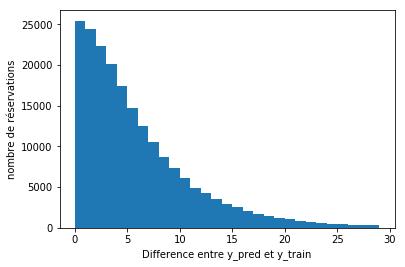

In [66]:
plt.hist(np.abs(y_pred-y_train), bins=range(0,30))
plt.xlabel('Difference entre y_pred et y_train')
plt.ylabel('nombre de réservations')

In [60]:
print(y_train.shape)
print(y_pred.shape)

(201686,)
(201686,)


In [61]:
y.shape

(252108,)

In [62]:
y_test.shape

(50422,)

# TEST ONLY

In [136]:
%%time
def RMSLE(y, pred):
    return metrics.mean_squared_error(y, pred)**0.5

model3 = XGBRegressor(learning_rate=0.2, random_state=3, n_estimators=250, subsample=0.8, colsample_bytree=0.8, max_depth=10)
model3.fit(train[col], np.log1p(train['visitors'].values))
preds3 = model3.predict(train[col])
print('RMSE XGBRegressor: ', RMSLE(np.log1p(train['visitors'].values), preds3))

KeyboardInterrupt: 

NameError: name 'df_result_hyperopt' is not defined

In [27]:
%%time
def RMSLE(y, pred):
    return metrics.mean_squared_error(y, pred)**0.5

model3 = XGBRegressor(learning_rate=0.1, n_estimators=1500, subsample=0.8, colsample_bytree=0.75, max_depth=1, gamma = 0.6000000000000001, 
                   min_child_weight=2, objective="reg:linear", reg_alpha=0.1, reg_lambda=0.5  )
model3.fit(train[col], np.log1p(train['visitors'].values))
preds3 = model3.predict(train[col])
print('RMSE XGBRegressor: ', RMSLE(np.log1p(train['visitors'].values), preds3))

RMSE XGBRegressor:  0.510622065292
CPU times: user 2min 37s, sys: 416 ms, total: 2min 38s
Wall time: 2min 38s


In [ ]:
%%time
model1 = ensemble.GradientBoostingRegressor(learning_rate=0.2, random_state=3, n_estimators=200, subsample=0.8, max_depth =10)
model1.fit(train[col], np.log1p(train['visitors'].values))
preds1 = model1.predict(train[col])
print('RMSE GradientBoostingRegressor: ', RMSLE(np.log1p(train['visitors'].values), preds1))

In [28]:
%%time
def RMSLE(y, pred):
    return metrics.mean_squared_error(y, pred)**0.5

model3 = XGBRegressor(learning_rate=0.2, random_state=3, n_estimators=250, subsample=0.8, colsample_bytree=0.8, max_depth =10)
model3.fit(train[col], np.log1p(train['visitors'].values))
preds3 = model3.predict(train[col])
print('RMSE XGBRegressor: ', RMSLE(np.log1p(train['visitors'].values), preds3))

RMSE XGBRegressor:  0.438197429237
CPU times: user 4min 1s, sys: 651 ms, total: 4min 2s
Wall time: 4min 2s


In [ ]:
# To do : Hyper parametres


In [ ]:
%%time
model2 = neighbors.KNeighborsRegressor(n_jobs=-1, n_neighbors=4)
model2.fit(train[col], np.log1p(train['visitors'].values))
preds2 = model2.predict(train[col])
print('RMSE KNeighborsRegressor: ', RMSLE(np.log1p(train['visitors'].values), preds2))

In [ ]:
dfs = { re.search('/([^/\.]*)\.csv', fn).group(1):
    pd.read_csv(fn)for fn in glob.glob('data/*.csv.zip')}